## Python Color Detection

This notebook allows us to automatically verify whether a button in a mobile app screenshot appears in the **expected color** (e.g., green for "enabled", gray for "disabled"). Instead of using average color (which can be affected by overlays like text), we detect the **dominant color** of the button region using `K-Means clustering`, after excluding near-white pixels.

---

### Workflow

1. **Load the screenshot**  
   Load the app screenshot and convert it to RGB format using OpenCV.

2. **Crop the button region**  
   Define the coordinates where the button appears and crop that region for analysis.

3. **Process the dominant color**  
   - Reshape the cropped image into a pixel array.
   - Filter out near-white pixels to avoid text/background interference.
   - Use K-Means to find the most frequent (dominant) color.

4. **Compare against expected color**  
   - Convert the detected color to hexadecimal.
   - Compare with the expected hex (e.g., `#35c759` for green).
   - Use Euclidean distance to determine if the match falls within a threshold.

---

### Global Variables

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from typing import Tuple, Dict, Union

### 1. Image Processing

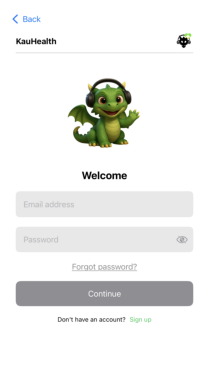

In [2]:
# Load first screenshot
screenshot_1 = cv2.imread('disabledbutton.png')
screenshot_1_rgb = cv2.cvtColor(screenshot_1, cv2.COLOR_BGR2RGB)

plt.imshow(screenshot_1_rgb)
plt.axis('off')
plt.show()

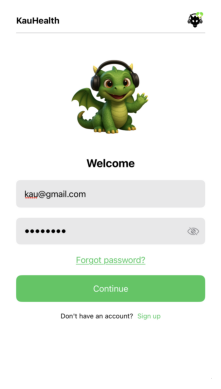

In [3]:
# Load second screenshot
screenshot_2 = cv2.imread('enabledbutton.png')
screenshot_2_rgb = cv2.cvtColor(screenshot_2, cv2.COLOR_BGR2RGB)

plt.imshow(screenshot_2_rgb)
plt.axis('off')
plt.show()

In [4]:
def crop_and_show(image_rgb, region):
    """
    Load an image, crop the specified region, and display it

    Args:
        image_rgb (np.ndarray): The image already loaded in RGB format
        region (Tuple[int, int, int, int]): (y1, y2, x1, x2) crop coordinates

    Returns:
        np.ndarray: The cropped RGB image
    """
    y1, y2, x1, x2 = region
    cropped = image_rgb[y1:y2, x1:x2]

    # Show cropped region
    plt.figure(figsize=(6, 2))
    plt.imshow(cropped)
    plt.axis('off')
    plt.show()
    return cropped

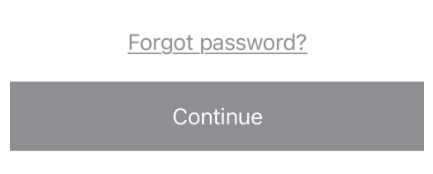

In [5]:
# Return the buttons only:

# Define region for the button
button_region = (770, 945, 60, 530)  # (y1, y2, x1, x2)

disabled_button = crop_and_show(screenshot_1_rgb, button_region)

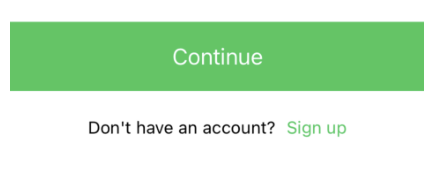

In [6]:
enabled_button = crop_and_show(screenshot_2_rgb, button_region)

### 2. Color Detection

In [7]:
def rgb_to_hex(rgb):
    """
    Convert an RGB color tuple or array to a hexadecimal color string

    Args:
        rgb (Union[np.ndarray, Tuple[float, float, float]]): The RGB color 
                                                             as a NumPy array or tuple

    Returns:
        str: Hexadecimal representation of the color
    """
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

def hex_to_rgb(hex_val):
    """
    Convert a hexadecimal color string to an RGB tuple

    Args:
        hex_val (str): The hex color string (e.g., '#35c759')

    Returns:
        Tuple[int, int, int]: Corresponding RGB values in a tuple
    """
    hex_val = hex_val.lstrip('#')
    return tuple(int(hex_val[i:i+2], 16) for i in (0, 2, 4))

def check_button_color_dominant(cropped_rgb, expected_hex, threshold = 30.0, n_clusters = 3):
    """
    Detect the dominant color in a cropped image, convert it to hex, and compare
    it against an expected hex color using Euclidean distance

    Args:
        cropped_rgb (np.ndarray): The cropped button image in RGB format
        expected_hex (str): The expected color in hexadecimal format
        threshold (float): Max distance to consider as match. Default 30.0
        n_clusters (int): Number of clusters for KMeans. Default 3

    Returns:
        Dict[str, Union[str, float, np.ndarray]]: Dictionary with color info and result
    """
    # Flatten image pixels
    pixels = cropped_rgb.reshape(-1, 3)

    # Exclude near-white pixels (those above 240 in all channels)
    non_white_pixels = pixels[np.all(pixels < [240, 240, 240], axis=1)]

    # Safety check: if all pixels were white
    if len(non_white_pixels) == 0:
        return {
            'Dominant RGB': np.array([255, 255, 255]),
            'Detected HEX': '#ffffff',
            'Distance to Expected': float('inf'),
            'Match Result': 'No dominant non-white pixels'
        }

    # KMeans clustering on filtered pixels
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    kmeans.fit(non_white_pixels)

    counts = np.bincount(kmeans.labels_)
    dominant_rgb = kmeans.cluster_centers_[np.argmax(counts)]

    # Convert and compare
    detected_hex = rgb_to_hex(dominant_rgb)
    expected_rgb = np.array(hex_to_rgb(expected_hex))
    distance = np.linalg.norm(dominant_rgb - expected_rgb)

    match = 'Matched' if distance < threshold else 'Not matched'

    return {
        'Dominant RGB': dominant_rgb.astype(int),
        'Detected HEX': detected_hex,
        'Distance to Expected': distance,
        'Match Result': match
    }

In [8]:
# Example usage with the Disabled and Enabled buttons

# Coordinates where the button appears in the screenshot
enabled_hex = '#65c465'
disabled_hex = '#8e8e93'

In [9]:
result_enabled = check_button_color_dominant(enabled_button, expected_hex=enabled_hex)
print(result_enabled)

{'Dominant RGB': array([101, 195, 102]), 'Detected HEX': '#65c366', 'Distance to Expected': 1.7032440568132161, 'Match Result': 'Matched'}


In [10]:
result_disabled = check_button_color_dominant(disabled_button, expected_hex=disabled_hex)
print(result_disabled)

{'Dominant RGB': array([142, 142, 147]), 'Detected HEX': '#8e8e93', 'Distance to Expected': 0.7512597700343812, 'Match Result': 'Matched'}
